# Real-Time American Sign Language Detection and Speech Synthesis

This notebook implements a real-time Word-Level American Sign Language detection system with speech output. The system will:

1. Capture video input from the webcam
2. Detect hand gestures and classify them as ASL signs
3. Convert recognized signs to text
4. Synthesize speech from the recognized text

This implementation uses a modular approach with code organized into the following modules:

- `mediapipe_utils.py`: MediaPipe detection and landmark utilities
- `data_processing.py`: Dataset creation and handling
- `model_utils.py`: Model training and evaluation
- `realtime_asl.py`: Real-time detection functionality
- `sign_model_builder.py`: LSTM model architecture

Let's get started by installing the necessary dependencies.

In [6]:
# Install requirements and run the script
!pip install -r requirements.txt
# Install tensorboard with pip ensuring it's in the correct Python environment
!pip install tensorboard
# Verify tensorboard is installed and find its location
!pip show tensorboard
# Find Python executable path which helps locate tensorboard
import sys
print(f"Python executable path: {sys.executable}")

  Preparing metadata (setup.py) ... done
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached funcy-2.0-py2.py3-none-any.whl.metadata (5.9 kB)
  Using cached google_auth-2.39.0-py2.py3-none-any.whl.metadata (6.2 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
Using cached cachetools-5.5.2-py3-none-any.whl (10 kB)
Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 12.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.1/925.1 kB 11.2 MB/s eta 0:00:00
Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 11.8 MB/s eta 0:00:00a 0:00:01
Using cached google_auth-2.39.0-py2.py3-none-any.whl (212 kB)
Using cached pyasn1-0.6.1-py3-none-any.whl (83 kB)
Using cached pyasn1_m

## Import Libraries

We'll import the necessary libraries and modules for our application.

In [1]:
import mediapipe as mp
import os
import pyttsx3
import torch
from module.helper_functions import plot_loss_curves
import datetime
from torch.utils.tensorboard import SummaryWriter

# Import our modular components
import sys
sys.path.append('./module')
from module.mediapipe_utils import setup_holistic_model
from module.data_processing import collect_sign_data
from module.model_utils import train, save_model
from module.realtime_asl import ASLDetector
from module.sign_model_builder import LSTM_Sign_Model
import torch

# Add necessary imports for the new model
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn as nn

# Initialize MediaPipe solutions (for backward compatibility with existing code)
mp_holistic = mp.solutions.holistic

## MediaPipe Setup

We're using the modular implementation from `mediapipe_utils.py` for hand tracking and landmark detection.

In [2]:
# Initialize MediaPipe solutions for visualization if needed
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# We're using the modular implementation for these functions:
# - mediapipe_detection from module.mediapipe_utils
# - draw_landmarks from module.mediapipe_utils
# - extract_keypoints from module.mediapipe_utils
# - setup_holistic_model from module.mediapipe_utils

## Keypoint Extraction

We're using the keypoint extraction functionality from our `module.mediapipe_utils` module, which extracts useful data from MediaPipe detections for our model.

In [4]:
# Using extract_keypoints from module.mediapipe_utils, which:
# 1. Extracts pose landmarks (33 points with x, y, z, visibility)
# 2. Extracts left hand landmarks (21 points with x, y, z) 
# 3. Extracts right hand landmarks (21 points with x, y, z)
# 4. Concatenates all points into a single feature vector

# This gives us a feature vector of length 258:

## Explore the Dataset

Let's explore the available data to understand what we're working with.

In [17]:
# List the available signs in our dataset
from module.helper_functions import get_data_path

data_path = os.path.join(get_data_path())
actions = os.listdir(data_path)
# Remove any hidden files (like .DS_Store)
actions = [action for action in actions if not action.startswith('.')]

print(f"Available signs: {actions}")

# Get some stats about the dataset
if actions:
    sign_folders = [folder for folder in os.listdir(os.path.join(data_path, actions[0])) 
                   if not folder.startswith('.')]
    num_sequences = len(sign_folders)
    
    # Use the first folder (with prefix) instead of assuming '0'
    if sign_folders:
        first_sequence = sign_folders[0]
        sequence_length = len([f for f in os.listdir(os.path.join(data_path, actions[0], first_sequence))
                              if not f.startswith('.')])
        
        print(f"Number of sequences per sign: {num_sequences}")
        print(f"Frames per sequence: {sequence_length}")
        print(f"Sequence folder format: {first_sequence} (contains prefix)")
    else:
        print("No sequence folders found.")
else:
    print("No sign actions found in the data path.")

Available signs: ['hello', 'iloveyou']
Number of sequences per sign: 4
Frames per sequence: 30
Sequence folder format: man_2 (contains prefix)


## Data Visualization

Let's visualize the sign language data to better understand the hand landmarks and their patterns.

Available signs: ['hello', 'iloveyou']

Visualizing sign: 'hello'


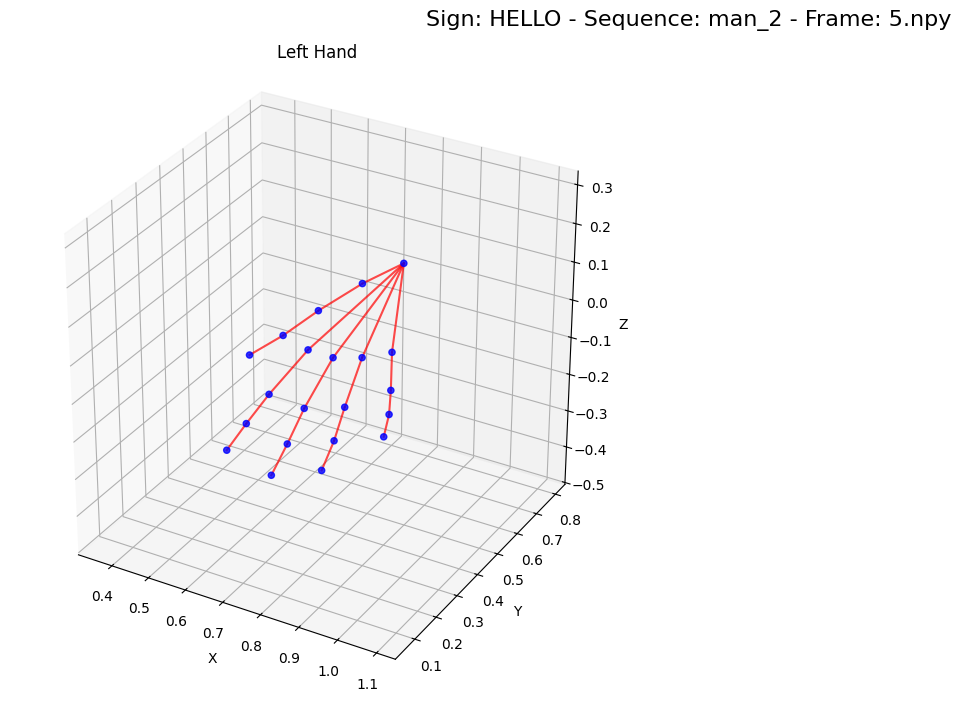

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

def visualize_hands_3d(left_hand=None, right_hand=None, title="Hand Landmarks"):
    """Visualize hand landmarks in 3D space.
    
    Args:
        left_hand: Numpy array of shape (63,) or (21,3) for left hand landmarks
        right_hand: Numpy array of shape (63,) or (21,3) for right hand landmarks
        title: Title for the plot
    """
    fig = plt.figure(figsize=(15, 7))
    fig.suptitle(title, fontsize=16)
    
    # Define connections between landmarks (hand skeleton)
    connections = [
        # Thumb
        (0, 1), (1, 2), (2, 3), (3, 4),
        # Index finger
        (0, 5), (5, 6), (6, 7), (7, 8),
        # Middle finger
        (0, 9), (9, 10), (10, 11), (11, 12),
        # Ring finger
        (0, 13), (13, 14), (14, 15), (15, 16),
        # Pinky
        (0, 17), (17, 18), (18, 19), (19, 20)
    ]
    
    # Plot Left Hand
    if left_hand is not None and np.any(left_hand != 0):
        # Reshape if needed
        if left_hand.shape[0] == 63:
            left_hand = left_hand.reshape(21, 3)
            
        ax_left = fig.add_subplot(121, projection='3d')
        ax_left.set_title("Left Hand")
        
        # Plot points
        ax_left.scatter(left_hand[:, 0], left_hand[:, 1], left_hand[:, 2], 
                      c='blue', marker='o', alpha=0.8)
        
        # Plot connections (skeleton)
        for start, end in connections:
            ax_left.plot([left_hand[start, 0], left_hand[end, 0]],
                       [left_hand[start, 1], left_hand[end, 1]],
                       [left_hand[start, 2], left_hand[end, 2]], 'r-', alpha=0.7)
            
        # Set labels and adjust view
        ax_left.set_xlabel('X')
        ax_left.set_ylabel('Y')
        ax_left.set_zlabel('Z')
        _set_axes_equal(ax_left, left_hand)
    
    # Plot Right Hand
    if right_hand is not None and np.any(right_hand != 0):
        # Reshape if needed
        if right_hand.shape[0] == 63:
            right_hand = right_hand.reshape(21, 3)
            
        ax_right = fig.add_subplot(122, projection='3d')
        ax_right.set_title("Right Hand")
        
        # Plot points
        ax_right.scatter(right_hand[:, 0], right_hand[:, 1], right_hand[:, 2], 
                       c='green', marker='o', alpha=0.8)
        
        # Plot connections (skeleton)
        for start, end in connections:
            ax_right.plot([right_hand[start, 0], right_hand[end, 0]],
                        [right_hand[start, 1], right_hand[end, 1]],
                        [right_hand[start, 2], right_hand[end, 2]], 'purple', alpha=0.7)
            
        # Set labels and adjust view
        ax_right.set_xlabel('X')
        ax_right.set_ylabel('Y')
        ax_right.set_zlabel('Z')
        _set_axes_equal(ax_right, right_hand)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    return fig

def _set_axes_equal(ax, points):
    """Set 3D plot axes to equal scale.
    
    Args:
        ax: 3D axis object
        points: points to use for scaling
    """
    # Find the range of data
    x_range = np.ptp(points[:, 0])
    y_range = np.ptp(points[:, 1])
    z_range = np.ptp(points[:, 2])
    
    # Find the center of data
    x_center = np.mean([points[:, 0].min(), points[:, 0].max()])
    y_center = np.mean([points[:, 1].min(), points[:, 1].max()])
    z_center = np.mean([points[:, 2].min(), points[:, 2].max()])
    
    # The max range for all axes
    max_range = max(x_range, y_range, z_range) / 2.0 * 1.1
    
    # Set the limits of the axes
    ax.set_xlim(x_center - max_range, x_center + max_range)
    ax.set_ylim(y_center - max_range, y_center + max_range)
    ax.set_zlim(z_center - max_range, z_center + max_range)
    
    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

def visualize_sign_samples(action, num_samples=2):
    """Visualize samples from a specific sign in the dataset.
    
    Args:
        action: Name of the sign action to visualize
        num_samples: Number of random samples to visualize
    """
    from module.helper_functions import get_data_path
    
    data_path = get_data_path()
    action_path = os.path.join(data_path, action)
    
    if not os.path.exists(action_path):
        print(f"Action '{action}' not found in the dataset.")
        return
        
    # Get sequences for this action
    sequences = [seq for seq in os.listdir(action_path) if not seq.startswith('.')]
    
    if not sequences:
        print(f"No sequences found for action '{action}'.")
        return
        
    # Limit samples to available sequences
    num_samples = min(num_samples, len(sequences))
    selected_sequences = random.sample(sequences, num_samples)
    
    for seq_idx, seq in enumerate(selected_sequences):
        seq_path = os.path.join(action_path, seq)
        frames = [f for f in os.listdir(seq_path) if f.endswith('.npy')]
        
        if not frames:
            print(f"No frames found for sequence '{seq}'.")
            continue
            
        # Choose a random frame
        frame_file = random.choice(frames)
        frame_path = os.path.join(seq_path, frame_file)
        frame_data = np.load(frame_path)
        
        # Extract left and right hand data
        left_hand = frame_data[:63]
        right_hand = frame_data[63:126]
        
        # Check if hands are present
        has_left = np.any(left_hand != 0)
        has_right = np.any(right_hand != 0)
        
        # Create plot title
        plot_title = f"Sign: {action.upper()} - Sequence: {seq} - Frame: {frame_file}"
        
        # Visualize the hands
        visualize_hands_3d(
            left_hand=left_hand if has_left else None,
            right_hand=right_hand if has_right else None,
            title=plot_title
        )
        plt.show()

# Check if the data directory exists before attempting to visualize
from module.helper_functions import get_data_path
data_path = get_data_path()

if os.path.exists(data_path):
    actions = [action for action in os.listdir(data_path) if not action.startswith('.')]
    if actions:
        print(f"Available signs: {actions}")
        
        # Visualize the first sign in the dataset
        example_sign = actions[0]
        print(f"\nVisualizing sign: '{example_sign}'")
        
        # Static visualization of a random sample
        try:
            visualize_sign_samples(example_sign, num_samples=1)
        except Exception as e:
            print(f"Error visualizing sign: {str(e)}")
    else:
        print("No sign data found. Please collect data first.")
else:
    print(f"Data directory not found at {data_path}. Please collect data first.")

## Set Up Text-to-Speech Engine

We'll use pyttsx3 for speech synthesis to convert detected signs to spoken words.

In [3]:
# Initialize the text-to-speech engine
engine = pyttsx3.init()

def speak(text):
    """Convert text to speech."""
    engine.say(text)
    engine.runAndWait()

## Data Collection Function

We'll use the modular function from `module.data_processing` to collect sign language data. This will help us build a custom dataset with our own gestures.

## Use the Data Collection Function

Run the cell below to collect data for a new sign. Follow these steps:
1. Enter the name of the sign you want to collect data for (e.g., 'thankyou', 'yes', 'no')
2. When the webcam starts, position yourself in front of the camera
3. After the 5-second countdown, perform the sign at a natural pace
4. Repeat for all sequences (default: 30)

To ensure good data quality:
- Maintain good lighting
- Keep a consistent background
- Try to perform the sign consistently each time
- Vary your position slightly between sequences for better model generalization

In [2]:
# Run this cell to collect data for a new sign
# Get camera index from user_config 
from module.helper_functions import get_cam_idx


camera_idx= get_cam_idx()
# Check if the camera index is valid
if camera_idx is None:
    print("No valid camera index found. Please check your camera settings.")
new_sign = input("Enter the name of the sign you want to collect data for: ")
num_seq = int(input("Enter the number of sequences to collect (default: 30): ") or 30)
seq_length = int(input("Enter the number of frames per sequence (default: 30): ") or 30)

print(f"\nPreparing to collect data for sign: '{new_sign}'")
print("Position yourself in front of the camera.")
print("Press Enter to start...")
input()

# Create holistic model for data collection
with setup_holistic_model() as holistic:
    collect_sign_data(new_sign, holistic, num_seq, seq_length, camera_idx)

# Update the actions list
if os.path.exists('data'):
    actions = [action for action in os.listdir('data') if not action.startswith('.')]
    print(f"Updated available signs: {actions}")


Preparing to collect data for sign: ''
Position yourself in front of the camera.
Press Enter to start...


I0000 00:00:1744950692.916481  356629 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1744950692.995030  357088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744950693.007949  357087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744950693.010079  357087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744950693.010124  357085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744950693.010284  357092 inference_feedback_manager.cc:114] Feedback manager requires a mod

KeyboardInterrupt: 

## Train with Separate Training and Testing Data

If you have separate datasets for training and testing, you can use the following function to train your model using both datasets.

In [3]:
import sys
sys.path.append('./module')
import torch
from module.data_processing import  organize_data_for_testing, create_dataloaders
from module.model_utils import train, save_model, plot_loss_curves
from module.realtime_asl import ASLDetector
from module.sign_model_builder import LSTM_Sign_Model
# Add necessary imports for the new model
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
organize_data_for_testing(train_split=0.8)

Removing existing directory: data_train
Removing existing directory: data_test
Data organized into data_train and data_test directories
Training data: 80%, Testing data: 20%


## TensorBoard Setup

We'll use TensorBoard for visualizing our training metrics. This provides a much more interactive way to track model performance than static plots.

In [4]:
# Create timestamp for unique run identification
def get_timestamp():
    return datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Function to create a TensorBoard writer with timestamp
def create_tensorboard_writer(base_dir="runs"):
    timestamp = get_timestamp()
    log_dir = os.path.join(base_dir, timestamp)
    os.makedirs(log_dir, exist_ok=True)
    return SummaryWriter(log_dir), timestamp

In [15]:
# Create new dataloaders with our fixed implementation
from os import times
import time

from module.helper_functions import get_runs_path


train_dir = "data_train"
test_dir = "data_test"
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
)

# Check if dataloaders are empty or have issues
print(f"Train dataloader length: {len(train_dataloader)}")
print(f"Test dataloader length: {len(test_dataloader)}")

# Check first batch in each dataloader
for batch_idx, (data, target) in enumerate(train_dataloader):
    print(f"Train batch {batch_idx}: data shape = {data.shape}, target shape = {target.shape}")
    break  # Just check the first batch
    
for batch_idx, (data, target) in enumerate(test_dataloader):
    print(f"Test batch {batch_idx}: data shape = {data.shape}, target shape = {target.shape}")
    break  # Just check the first batch
    
# Update the model for the correct number of classes
NUM_EPOCHS = 5
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
INPUT_SIZE = 126  # Updated: Left Hand (21*3) + Right Hand (21*3) = 63 + 63 = 126

# Initialize model using our modular structure
model = LSTM_Sign_Model(
    input_size=INPUT_SIZE, 
    hidden_size=HIDDEN_UNITS,
    num_layers=1,  # Setting num_layers to 1 instead of NUM_EPOCHS which was incorrect
    num_classes=len(class_names) 
)

# LOSS FUNCTION AND OPTIMIZER
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),eps=1e-7, lr=LEARNING_RATE)

timestamp = get_timestamp()

# Create the runs directory if it doesn't exist
runs_dir = get_runs_path()
os.makedirs(runs_dir, exist_ok=True)
os.makedirs(f"{runs_dir}/{timestamp}", exist_ok=True)

writer = SummaryWriter(f"{runs_dir}/{timestamp}")
        
# Make sure model is on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model batch normalization parameters to verify dimensions
print(f"BatchNorm1 parameters: {model.batch_norm1}")
print(f"Input size: {INPUT_SIZE}")

Train dataloader length: 1
Test dataloader length: 1
Train batch 0: data shape = torch.Size([6, 30, 126]), target shape = torch.Size([6])
Test batch 0: data shape = torch.Size([2, 30, 126]), target shape = torch.Size([2])
BatchNorm1 parameters: BatchNorm1d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Input size: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8797 | train_acc: 0.5000 | test_loss: 0.6924 | test_acc: 0.5000


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

Epoch: 2 | train_loss: 0.7341 | train_acc: 1.0000 | test_loss: 0.6894 | test_acc: 0.5000


 40%|████      | 2/5 [00:01<00:02,  1.30it/s]

Epoch: 3 | train_loss: 0.4530 | train_acc: 1.0000 | test_loss: 0.6813 | test_acc: 0.5000


 60%|██████    | 3/5 [00:02<00:01,  1.32it/s]

Epoch: 4 | train_loss: 0.2551 | train_acc: 1.0000 | test_loss: 0.7533 | test_acc: 0.5000


 80%|████████  | 4/5 [00:03<00:00,  1.33it/s]

Epoch: 5 | train_loss: 0.1868 | train_acc: 1.0000 | test_loss: 1.0369 | test_acc: 0.5000


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

Model saved as '/Users/mandev/Library/CloudStorage/OneDrive-man1605/Sign_Language/model/sign_language_model_20250418-113929.pth'
Model saved to /Users/mandev/Library/CloudStorage/OneDrive-man1605/Sign_Language/model/sign_language_model_20250418-113929.pth
Model saved as '/Users/mandev/Library/CloudStorage/OneDrive-man1605/Sign_Language/model/sign_language_model.pth'


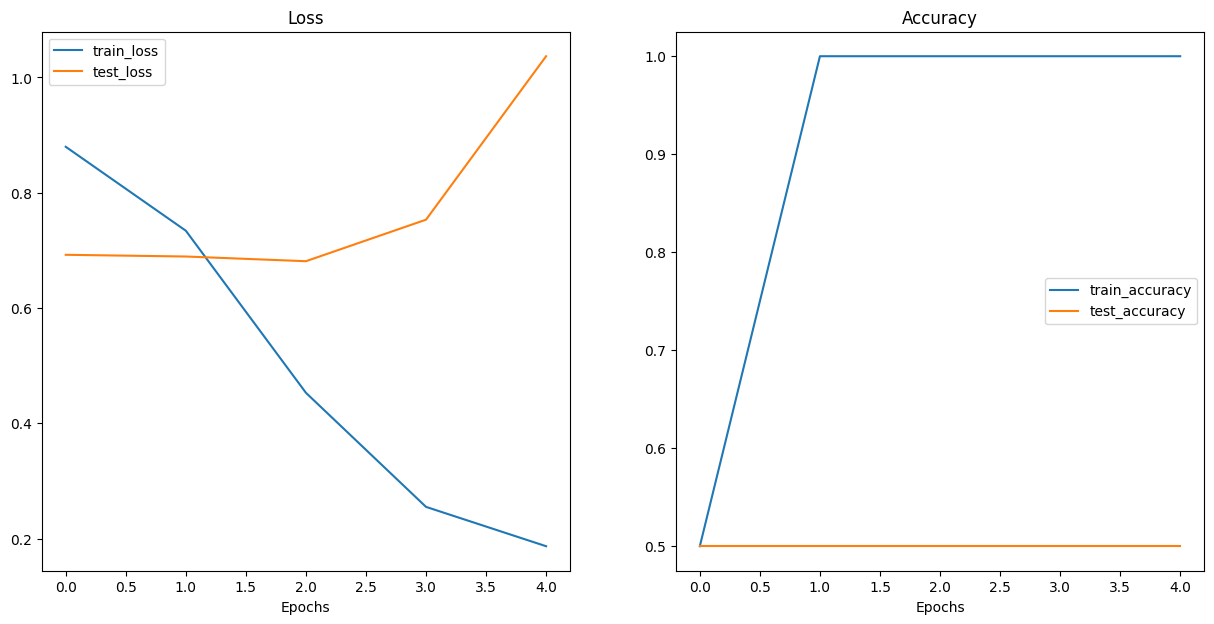

In [16]:
# Use the enhanced train_with_tensorboard function from module.model_utils
from module.model_utils import  save_model, train
from module.helper_functions import get_model_path, plot_loss_curves

# Train the model with the enhanced TensorBoard support
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=criterion,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    writer=writer
)

# Save the model with timestamp
model_save_path = f'{get_model_path()}/sign_language_model_{timestamp}.pth'
save_model(
    model=model,
    path=model_save_path,
)
print(f"Model saved to {model_save_path}")

# Also save as the default model for easier loading
save_model(
    model=model,
    path=f'{get_model_path()}/sign_language_model.pth',
)

# Plot loss curves
plot_loss_curves(results)

## Launch TensorBoard

Run the cell below to launch TensorBoard. You can view the training metrics in an interactive dashboard.

In [17]:
# Alternative ways to run TensorBoard

# Method 1: Using %tensorboard magic command (already tried)
tb_path = os.path.join(get_runs_path())
print(f"Launching TensorBoard from directory: {tb_path}")

try:
    %load_ext tensorboard
    %tensorboard --logdir=runs
except Exception as e:
    print(f"Magic command failed: {str(e)}")

# Method 2: Find the tensorboard executable and set it explicitly
import sys
import subprocess
from shutil import which

# Find Python's site-packages directory where tensorboard should be installed
python_exec = sys.executable
print(f"Python executable: {python_exec}")

# Try to find tensorboard using the which command
tb_path_exec = which('tensorboard')
if tb_path_exec:
    print(f"Found tensorboard at: {tb_path_exec}")
    # Set the environment variable
    import os
    os.environ['TENSORBOARD_BINARY'] = tb_path_exec
    # Try the magic command again
    try:
        %tensorboard --logdir=runs
    except Exception as e:
        print(f"Still couldn't launch tensorboard: {e}")
else:
    print("Could not find tensorboard executable. Installing it directly:")
    !{python_exec} -m pip install -U tensorboard

# Method 3: Launch tensorboard through Python API
try:
    from tensorboard import program
    tb = program.TensorBoard()
    tb.configure(argv=[None, '--logdir', tb_path])
    url = tb.launch()
    print(f"TensorBoard started at {url}")
except Exception as e:
    print(f"Failed to launch TensorBoard through API: {e}")

# Method 4: Run tensorboard as a subprocess
try:
    print("Starting TensorBoard as a subprocess...")
    !{python_exec} -m tensorboard.main --logdir={tb_path}
except Exception as e:
    print(f"Failed to start TensorBoard as subprocess: {e}")

print("")
print("If TensorBoard still doesn't launch, try running this command in your terminal:")
print(f"cd {os.getcwd()} && tensorboard --logdir=runs")

Launching TensorBoard from directory: /Users/mandev/Library/CloudStorage/OneDrive-man1605/Sign_Language/runs


Launching TensorBoard...

Python executable: /Users/mandev/Workspace/UNI/ChuyenNganh/venv/bin/python
Could not find tensorboard executable. Installing it directly:

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
TensorBoard started at http://localhost:6006/
Starting TensorBoard as a subprocess...
TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.19.0 at http://localhost:6007/ (Press CTRL+C to quit)
Failed to start TensorBoard as subprocess: [Errno 5] Input/output error

If TensorBoard still doesn't launch, try running this command in your terminal:
cd /Users/mandev/Workspace/UNI/ChuyenNganh && tensorboard --logdir=runs


## Real-Time Detection with PyTorch

Now, let's implement the real-time detection using our PyTorch model and the modular ASLDetector class.

In [14]:
# Create a detector instance using our modular implementation
# Use the latest trained model by default or specify a particular timestamp model
# model_path = 'model/sign_language_model.pth'  # Default model path

# Uncomment to use a specific timestamped model
model_path = f'{get_model_path()}/sign_language_model_{timestamp}.pth'

detector = ASLDetector(model_path=model_path, 
                      threshold=0.7,
                      sequence_length=30, 
                      device=device)

# Start real-time detection
detector.detect_in_realtime(camera_idx=camera_idx)

Model loaded with weights_only=False for backward compatibility
Loaded model from /Users/mandev/Library/CloudStorage/OneDrive-man1605/Sign_Language/model/sign_language_model_20250418-113742.pth


I0000 00:00:1744951128.897808  356629 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1744951128.971201  366895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744951128.984120  366899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744951128.986995  366899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744951128.987075  366894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744951128.987313  366898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

IndexError: list index out of range

## Model Management

The following cell lets you list and load models saved with timestamps. This is useful when you have trained multiple models and want to compare their performance.

In [10]:
# List all saved models
model_dir = 'model'
model_files = [f for f in os.listdir(model_dir) if f.startswith('sign_language_model_') and f.endswith('.pth')]
print("Available models:")
for i, model_file in enumerate(model_files):
    timestamp = model_file.replace('sign_language_model_', '').replace('.pth', '')
    print(f"{i+1}. Model trained at {timestamp}")

# Function to load a specific model by timestamp
def load_model_by_timestamp(timestamp):
    model_path = f'model/sign_language_model_{timestamp}.pth'
    model = torch.load(model_path)
    print(f"Loaded model trained at {timestamp}")
    return model

# Example usage:
# selected_timestamp = "20250416-123456"  # Replace with an actual timestamp
# loaded_model = load_model_by_timestamp(selected_timestamp)

Available models:
1. Model trained at 20250416-230749
2. Model trained at 20250416-212336
3. Model trained at 20250416-212916
4. Model trained at 20250416-212634


## Left-Hand vs Right-Hand Data Analysis

Sign language recognition models need to handle differences between left-handed and right-handed signers. Let's analyze our current data structure and implement data augmentation to improve model robustness.

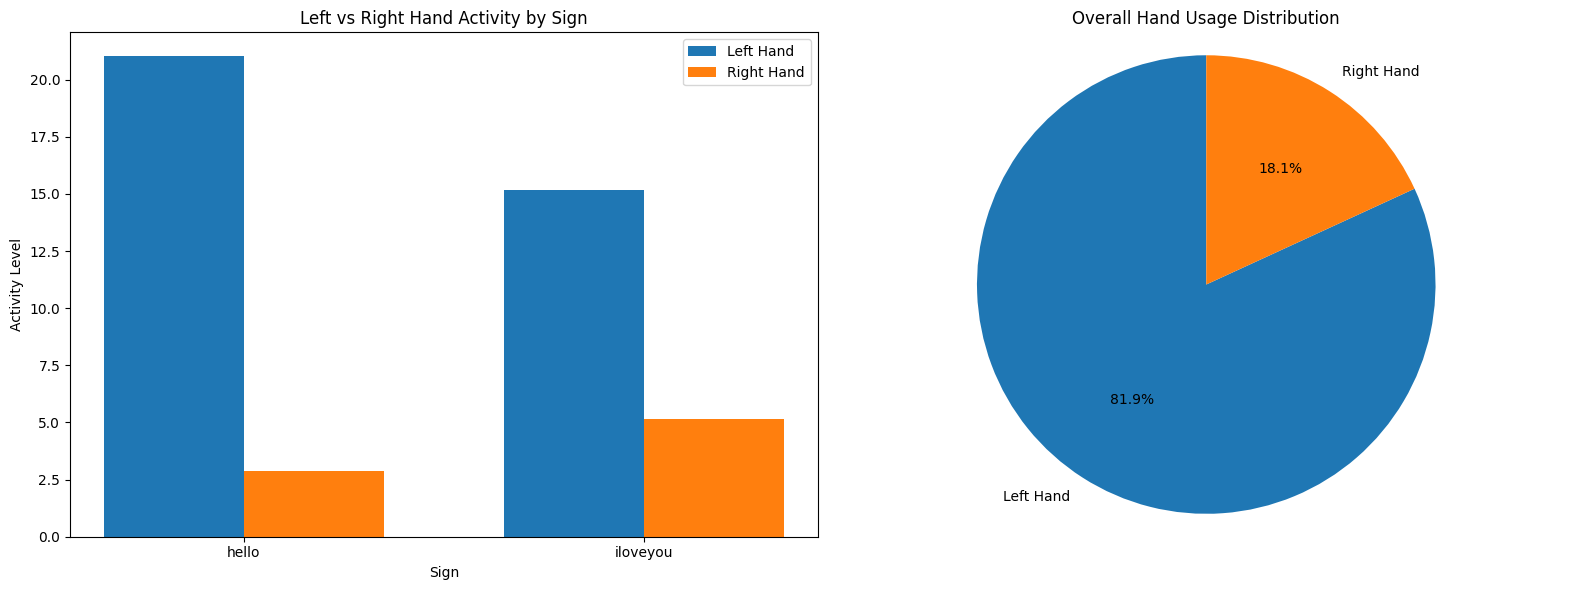

In [31]:
# Analysis of left hand vs right hand data
import matplotlib.pyplot as plt
import numpy as np
import os

def analyze_hand_dominance(data_dir='data'):
    """Analyze the activity levels between left and right hands in the training data."""
    actions = [action for action in os.listdir(data_dir) if not action.startswith('.')]
    left_activity = {}
    right_activity = {}
    
    for action in actions:
        left_total = 0
        right_total = 0
        sample_count = 0
        
        # Process each sequence for this action
        seqs = [seq for seq in os.listdir(os.path.join(data_dir, action)) if not seq.startswith('.')]
        for seq in seqs[:5]:  # Limit to first 5 sequences for speed
            frames = [f for f in os.listdir(os.path.join(data_dir, action, seq)) if f.endswith('.npy')]
            for frame in frames:
                data = np.load(os.path.join(data_dir, action, seq, frame))
                # Extract left hand (first 63 values) and right hand (next 63 values)
                left_hand = data[:63]
                right_hand = data[63:126]
                
                # Calculate activity as sum of absolute values
                left_activity_frame = np.sum(np.abs(left_hand))
                right_activity_frame = np.sum(np.abs(right_hand))
                
                left_total += left_activity_frame
                right_total += right_activity_frame
                sample_count += 1
        
        if sample_count > 0:
            left_avg = left_total / sample_count
            right_avg = right_total / sample_count
            left_activity[action] = left_avg
            right_activity[action] = right_avg
    
    # Visualize the results
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart of left vs right hand activity per sign
    x = np.arange(len(actions))
    width = 0.35
    
    left_values = [left_activity[a] for a in actions]
    right_values = [right_activity[a] for a in actions]
    
    ax[0].bar(x - width/2, left_values, width, label='Left Hand')
    ax[0].bar(x + width/2, right_values, width, label='Right Hand')
    ax[0].set_xlabel('Sign')
    ax[0].set_ylabel('Activity Level')
    ax[0].set_title('Left vs Right Hand Activity by Sign')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(actions)
    ax[0].legend()
    
    # Pie chart showing overall left vs right hand usage
    total_left = sum(left_values)
    total_right = sum(right_values)
    ax[1].pie([total_left, total_right], labels=['Left Hand', 'Right Hand'], 
             autopct='%1.1f%%', startangle=90)
    ax[1].axis('equal')
    ax[1].set_title('Overall Hand Usage Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return left_activity, right_activity

# Analyze hand dominance in our dataset
left_activity, right_activity = analyze_hand_dominance()

## Data Augmentation: Hand Swapping

To make our model more robust to differences between left-handed and right-handed signers, we can implement data augmentation by swapping left and right hand data. This creates new training examples that represent how the signs might look when performed with the opposite dominant hand.

In [32]:
def swap_hands(keypoints):
    """Swap left and right hand keypoints in a feature vector.
    
    Args:
        keypoints: NumPy array of shape (126,) containing left hand (first 63)
                  and right hand (next 63) landmark coordinates
    
    Returns:
        NumPy array with swapped hand positions
    """
    # Extract left and right hand landmarks
    left_hand = keypoints[:63]
    right_hand = keypoints[63:126]
    
    # Create new feature vector with swapped hands
    swapped_keypoints = np.concatenate([right_hand, left_hand])
    
    return swapped_keypoints

def augment_with_hand_swaps(data_dir='data', output_dir='data_augmented', augment_ratio=0.5):
    """Create an augmented dataset by swapping left and right hands in a portion of the data.
    
    Args:
        data_dir: Directory containing original data
        output_dir: Directory to save augmented data
        augment_ratio: Fraction of data to augment (0.0 to 1.0)
    """
    import os
    import numpy as np
    import shutil
    import random
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get list of actions
    actions = [action for action in os.listdir(data_dir) if not action.startswith('.')]
    
    for action in actions:
        # Create action directory
        action_dir = os.path.join(output_dir, action)
        os.makedirs(action_dir, exist_ok=True)
        
        # Get sequences for this action
        sequences = [seq for seq in os.listdir(os.path.join(data_dir, action)) 
                     if not seq.startswith('.')]
        
        # Copy original sequences
        for seq in sequences:
            # Create sequence directory
            seq_dir = os.path.join(action_dir, seq)
            os.makedirs(seq_dir, exist_ok=True)
            
            # Copy all frames
            frames = [f for f in os.listdir(os.path.join(data_dir, action, seq)) 
                     if f.endswith('.npy')]
            for frame in frames:
                original_path = os.path.join(data_dir, action, seq, frame)
                target_path = os.path.join(seq_dir, frame)
                shutil.copyfile(original_path, target_path)
        
        # Create augmented sequences with swapped hands
        num_to_augment = int(len(sequences) * augment_ratio)
        seqs_to_augment = random.sample(sequences, num_to_augment)
        
        next_seq_idx = max([int(seq) for seq in sequences]) + 1
        
        for orig_seq in seqs_to_augment:
            # Create augmented sequence directory
            aug_seq = str(next_seq_idx)
            next_seq_idx += 1
            aug_seq_dir = os.path.join(action_dir, aug_seq)
            os.makedirs(aug_seq_dir, exist_ok=True)
            
            # Process all frames in the sequence
            frames = [f for f in os.listdir(os.path.join(data_dir, action, orig_seq)) 
                     if f.endswith('.npy')]
            
            for frame in frames:
                # Load original frame data
                original_path = os.path.join(data_dir, action, orig_seq, frame)
                keypoints = np.load(original_path)
                
                # Swap hands
                swapped_keypoints = swap_hands(keypoints)
                
                # Save augmented frame
                target_path = os.path.join(aug_seq_dir, frame)
                np.save(target_path, swapped_keypoints)
        
    print(f"Augmented dataset created in '{output_dir}' with {augment_ratio*100}% hand-swapped data")
    return output_dir

# Example usage of the hand swapping augmentation
# To create the augmented dataset, uncomment and run the following line:
# augment_with_hand_swaps(augment_ratio=0.3)

## Visualize Original vs Swapped Hand Data

Let's compare original hand keypoints with swapped hand keypoints to understand the effect of our data augmentation technique.

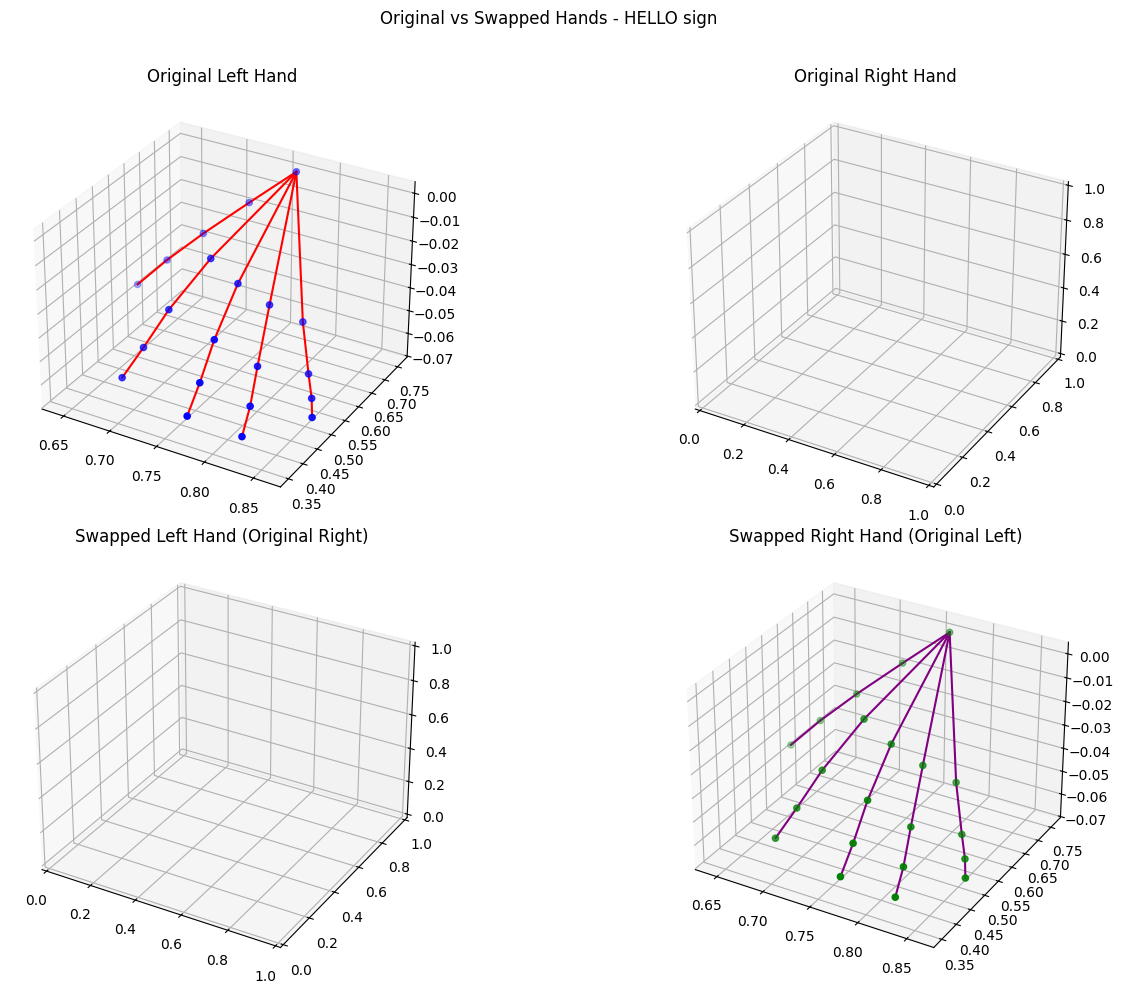

In [33]:
def visualize_hand_swap(action='hello', seq_idx=0, frame_idx=15):
    """Visualize a comparison of original vs hand-swapped keypoints."""
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np
    
    # Load a sample frame
    frame_path = os.path.join('data', action, str(seq_idx), f"{frame_idx}.npy")
    if not os.path.exists(frame_path):
        print(f"File not found: {frame_path}")
        return
        
    # Load keypoints
    keypoints = np.load(frame_path)
    swapped_keypoints = swap_hands(keypoints)
    
    # Extract hands from original and swapped data
    orig_left_hand = keypoints[:63].reshape(21, 3)
    orig_right_hand = keypoints[63:126].reshape(21, 3)
    
    swapped_left_hand = swapped_keypoints[:63].reshape(21, 3)
    swapped_right_hand = swapped_keypoints[63:126].reshape(21, 3)
    
    # Create figure with 2x2 subplots
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(f"Original vs Swapped Hands - {action.upper()} sign")
    
    # Define connections between landmarks for visualization
    connections = [
        # Thumb
        (0, 1), (1, 2), (2, 3), (3, 4),
        # Index finger
        (0, 5), (5, 6), (6, 7), (7, 8),
        # Middle finger
        (0, 9), (9, 10), (10, 11), (11, 12),
        # Ring finger
        (0, 13), (13, 14), (14, 15), (15, 16),
        # Pinky
        (0, 17), (17, 18), (18, 19), (19, 20)
    ]
    
    # Plot original left hand
    ax1 = fig.add_subplot(221, projection='3d')
    if np.any(orig_left_hand != 0):
        ax1.scatter(orig_left_hand[:, 0], orig_left_hand[:, 1], orig_left_hand[:, 2], c='b', marker='o')
        for start, end in connections:
            ax1.plot([orig_left_hand[start, 0], orig_left_hand[end, 0]],
                     [orig_left_hand[start, 1], orig_left_hand[end, 1]],
                     [orig_left_hand[start, 2], orig_left_hand[end, 2]], 'r')
    ax1.set_title("Original Left Hand")
    
    # Plot original right hand
    ax2 = fig.add_subplot(222, projection='3d')
    if np.any(orig_right_hand != 0):
        ax2.scatter(orig_right_hand[:, 0], orig_right_hand[:, 1], orig_right_hand[:, 2], c='b', marker='o')
        for start, end in connections:
            ax2.plot([orig_right_hand[start, 0], orig_right_hand[end, 0]],
                     [orig_right_hand[start, 1], orig_right_hand[end, 1]],
                     [orig_right_hand[start, 2], orig_right_hand[end, 2]], 'r')
    ax2.set_title("Original Right Hand")
    
    # Plot swapped left hand
    ax3 = fig.add_subplot(223, projection='3d')
    if np.any(swapped_left_hand != 0):
        ax3.scatter(swapped_left_hand[:, 0], swapped_left_hand[:, 1], swapped_left_hand[:, 2], c='g', marker='o')
        for start, end in connections:
            ax3.plot([swapped_left_hand[start, 0], swapped_left_hand[end, 0]],
                     [swapped_left_hand[start, 1], swapped_left_hand[end, 1]],
                     [swapped_left_hand[start, 2], swapped_left_hand[end, 2]], 'purple')
    ax3.set_title("Swapped Left Hand (Original Right)")
    
    # Plot swapped right hand
    ax4 = fig.add_subplot(224, projection='3d')
    if np.any(swapped_right_hand != 0):
        ax4.scatter(swapped_right_hand[:, 0], swapped_right_hand[:, 1], swapped_right_hand[:, 2], c='g', marker='o')
        for start, end in connections:
            ax4.plot([swapped_right_hand[start, 0], swapped_right_hand[end, 0]],
                     [swapped_right_hand[start, 1], swapped_right_hand[end, 1]],
                     [swapped_right_hand[start, 2], swapped_right_hand[end, 2]], 'purple')
    ax4.set_title("Swapped Right Hand (Original Left)")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Visualize the hand swapping on a sample
try:
    visualize_hand_swap(action='hello', seq_idx=0, frame_idx=15)
except Exception as e:
    print(f"Error visualizing hand swap: {str(e)}")

## Training with Augmented Data

Below is a function that creates an augmented dataset and trains a model on it. This approach helps the model become more robust to differences between left and right-handed signing patterns.

In [35]:
def train_with_augmented_data(augment_ratio=0.3, epochs=5, base_model=None):
    """Create an augmented dataset and train a model on it.
    
    Args:
        augment_ratio: Fraction of data to augment with hand-swapping
        epochs: Number of training epochs
        base_model: Optional pre-trained model to continue training
        
    Returns:
        Trained model and training results
    """
    import torch
    from module.sign_model_builder import LSTM_Sign_Model
    from module.data_processing import create_dataloaders
    from module.model_utils import train, save_model
    from torch.utils.tensorboard import SummaryWriter
    import datetime
    import os
    import shutil
    
    # Create augmented dataset
    print("Creating augmented dataset...")
    aug_data_dir = augment_with_hand_swaps(augment_ratio=augment_ratio)
    
    # Since organize_data_for_testing() doesn't accept a data_dir parameter,
    # we need to temporarily rename our directories to use it
    print("Organizing data for testing...")
    
    # Back up original data directory if it exists
    if os.path.exists('data_original_backup'):
        print("Removing existing backup directory")
        shutil.rmtree('data_original_backup')
        
    if os.path.exists('data'):
        print("Backing up original data directory")
        shutil.copytree('data', 'data_original_backup')
    
    # Replace 'data' with our augmented data
    if os.path.exists('data'):
        print("Removing existing data directory")
        shutil.rmtree('data')
    
    print("Moving augmented data to 'data' directory")
    shutil.copytree(aug_data_dir, 'data')
    
    # Now call organize_data_for_testing with the augmented data in 'data'
    from module.data_processing import organize_data_for_testing
    organize_data_for_testing(train_split=0.8)
    
    # Create dataloaders
    print("Creating dataloaders...")
    train_dataloader, test_dataloader, class_names = create_dataloaders(
        train_dir="data_train",
        test_dir="data_test",
        batch_size=32
    )
    
    # Initialize model or use provided base model
    if base_model is None:
        print("Creating new model...")
        model = LSTM_Sign_Model(
            input_size=126,  # Left hand (21*3) + Right hand (21*3)
            hidden_size=16,
            num_layers=1,
            num_classes=len(class_names)
        )
    else:
        print("Using provided base model...")
        model = base_model
    
    # Set up training
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Create TensorBoard writer
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(f"runs/{timestamp}_augmented")
    
    # Train model
    print("Training model...")
    results = train(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        loss_fn=criterion,
        optimizer=optimizer,
        epochs=epochs,
        device=device,
        writer=writer
    )
    
    # Save model
    model_save_path = f'model/sign_language_model_{timestamp}_augmented.pth'
    save_model(model=model, path=model_save_path)
    print(f"Model saved to {model_save_path}")
    
    # Restore original data directory
    if os.path.exists('data_original_backup'):
        print("Restoring original data directory")
        if os.path.exists('data'):
            shutil.rmtree('data')
        shutil.copytree('data_original_backup', 'data')
        shutil.rmtree('data_original_backup')
    
    return model, results

# Uncomment to train with augmented data
model_augmented, results_augmented = train_with_augmented_data(augment_ratio=0.3, epochs=3)

Creating augmented dataset...
Augmented dataset created in 'data_augmented' with 30.0% hand-swapped data
Organizing data for testing...
Backing up original data directory
Augmented dataset created in 'data_augmented' with 30.0% hand-swapped data
Organizing data for testing...
Backing up original data directory
Removing existing data directory
Moving augmented data to 'data' directory
Removing existing data directory
Moving augmented data to 'data' directory
Removing existing directory: data_train
Removing existing directory: data_test
Removing existing directory: data_train
Removing existing directory: data_test
Data organized into data_train and data_test directories
Training data: 80%, Testing data: 20%
Creating dataloaders...
Creating new model...
Training model...
Data organized into data_train and data_test directories
Training data: 80%, Testing data: 20%
Creating dataloaders...
Creating new model...
Training model...


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8460 | train_acc: 0.6349 | test_loss: 0.6914 | test_acc: 0.5000


 33%|███▎      | 1/3 [00:02<00:04,  2.03s/it]

Epoch: 2 | train_loss: 0.7716 | train_acc: 0.7143 | test_loss: 0.7209 | test_acc: 0.5000


 67%|██████▋   | 2/3 [00:03<00:01,  1.98s/it]

Epoch: 3 | train_loss: 0.4875 | train_acc: 0.8571 | test_loss: 0.6768 | test_acc: 0.5000


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]



Model saved as 'model/sign_language_model_20250417-210509_augmented.pth'
Model saved to model/sign_language_model_20250417-210509_augmented.pth
Restoring original data directory


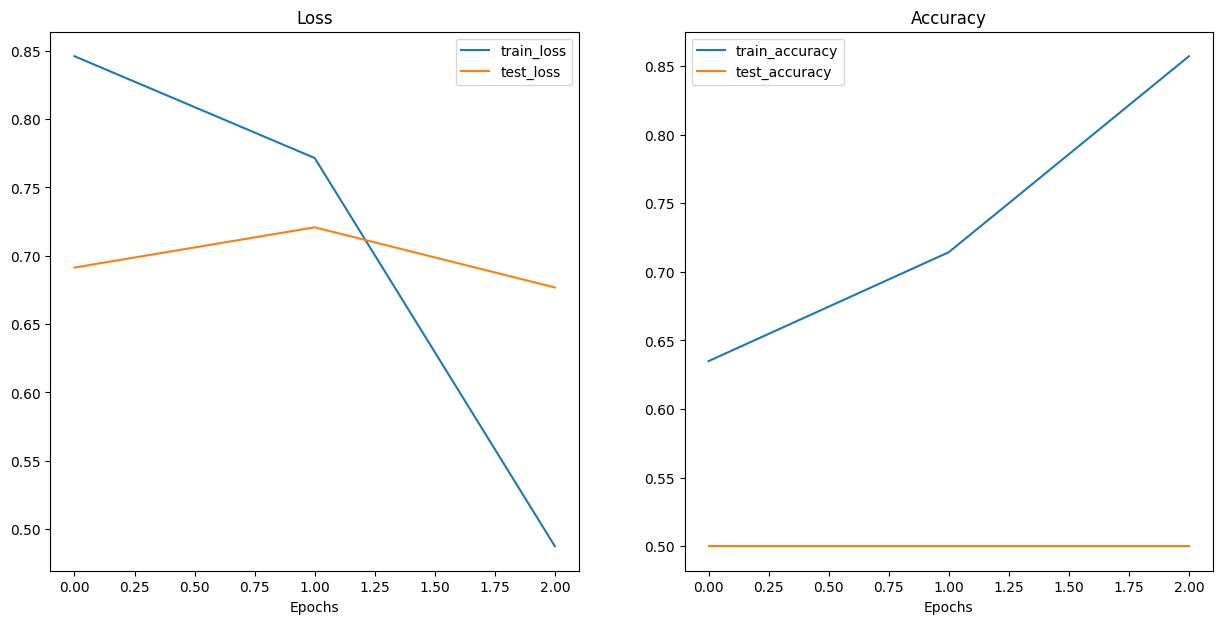

In [37]:
from module.helper_functions import plot_loss_curves
plot_loss_curves(results_augmented)

## Conclusion: Handling Left vs Right Hand Differences

Our sign language model handles differences between left and right hands in several ways:

1. **Data Structure**: The model explicitly tracks both hands separately (63 features for each hand), allowing it to learn patterns specific to each hand's movement.

2. **Data Augmentation**: We implemented hand-swapping augmentation to make the model robust to variations in hand dominance, helping it recognize signs from both left-handed and right-handed users.

3. **Feature Representation**: The 3D coordinate system captures the spatial relationships between keypoints regardless of which hand is dominant.

For optimal performance, especially with asymmetrical signs, training with a diverse dataset that includes both left-handed and right-handed signers is recommended. The data augmentation approach simulates this diversity when collecting data from both types of signers is not feasible.

## Future Improvements

Here are some potential improvements for the application:

1. **Sentence Formation**: Implement grammar rules to form proper sentences from detected signs.
2. **Continuous Sign Language Recognition**: Improve the model to handle continuous signing.
3. **User Interface**: Create a more user-friendly interface with settings for sensitivity and speech voice.
4. **Mobile Application**: Convert the system to a mobile application for wider accessibility.
5. **Expanded Vocabulary**: Train the model on a larger dataset to recognize more signs.
6. **Two-Way Translation**: Add speech-to-sign functionality for two-way communication.

## Conclusion

This notebook demonstrates a real-time American Sign Language detection and speech synthesis system. The application uses:

1. MediaPipe for hand tracking and landmark detection
2. PyTorch for sign classification using an LSTM model
3. OpenCV for video capture and visualization
4. pyttsx3 for text-to-speech conversion

The system can detect Word-Level ASL signs and convert them to speech in real-time, providing a valuable tool for sign language communication.